<a href="https://colab.research.google.com/github/akash-agni/DeepLearning/blob/main/Pneumonia_Identifier_Using_Chest_XRay_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:29<00:00, 38.1MB/s]
100% 2.29G/2.29G [00:29<00:00, 84.3MB/s]


In [3]:
! mkdir ./data
! unzip chest-xray-pneumonia.zip -d ./data > extract.log
! rm -rf chest-xray-pneumonia.zip

In [14]:
import os, time
import numpy as np
import torch
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics as mtr

import torch
from torchvision.transforms import ToTensor
from torchvision.models import resnet18

In [5]:
class chest_xray_data(object):

  def __init__(self, root, split, transforms=None):
    self.root = root
    self.transforms = transforms
    self.data_dir = os.path.join(root, split)
    self.imgs = [(i, 'NORMAL') for i in list(sorted(os.listdir(os.path.join(self.data_dir, 'NORMAL'))))]
    self.imgs += [(i, 'PNEUMONIA') for i  in list(sorted(os.listdir(os.path.join(self.data_dir, 'PNEUMONIA'))))]

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    img_path = os.path.join(self.data_dir, self.imgs[idx][1], self.imgs[idx][0])
    img = Image.open(img_path).convert('RGB').resize((448, 448))
    img = np.moveaxis(np.array(img)/255.0, -1, 0)
    label = 0 if self.imgs[idx][1] == 'NORMAL' else 1
    if self.transforms is not None:
      img, label = self.transforms(img, label)
    return img, label


In [6]:
train_data = chest_xray_data('/content/data/chest_xray', 'train')
test_data = chest_xray_data('/content/data/chest_xray', 'test')

In [7]:
train_dataloader = torch.utils.data.DataLoader(train_data, 64, True)
test_dataloader = torch.utils.data.DataLoader(test_data, 64, True)

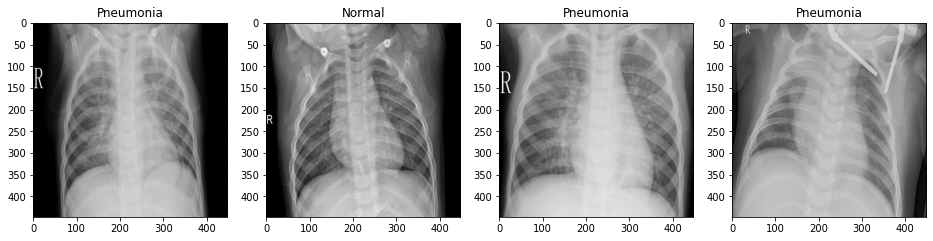

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 4))
for i in train_dataloader:
  for j in range(4):
    img = i[0][j]
    label = i[1][j]
    ax[j].imshow(np.moveaxis(img.numpy(), 0, -1))
    ax[j].set_title('Normal' if label == 0 else 'Pneumonia')
  break

In [9]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    
    pred = model(X.float())
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % int(size/10) == 0:
      loss, current = loss.item(), batch
      print(f"loss: {loss:>7f}  [{current:>2d}/{size:>2d}]")

In [20]:
def test(dataloader, model):
  size = len(dataloader.dataset)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X.float())
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= size
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss:{test_loss:>8f} \n")
  return test_loss

In [11]:
model = resnet18(pretrained=True)
for param in model.parameters():
  param.requires_grad = False
in_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features, 128),
    torch.nn.BatchNorm1d(128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 32),
    torch.nn.BatchNorm1d(32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 2),
    torch.nn.Sigmoid()
)
#model.fc = torch.nn.Linear(in_features, 2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [12]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-3, momentum=0.7, weight_decay=0.0005)
loss_fn = torch.nn.CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else  'cpu'
num_epochs = 25
print(f"Model Is Running On {device}")

Model Is Running On cuda


In [21]:
start_time = time.time()
best_loss_score = test(test_dataloader, model.to(device))
end_time = time.time()
print(f"Elapsed TIme :=> {np.round(end_time - start_time,3)} sec")

Test Error: 
 Accuracy: 34.1%, Avg loss:0.011134 

Elapsed TIme :=> 19.415 sec


In [23]:
best_model = model.state_dict()
for i in range(num_epochs):
  print(f"Epoch {i+1}\n-------------------------------")
  start_time = time.time()
  train(train_dataloader, model.to(device), loss_fn, optimizer)
  test_loss = test(test_dataloader, model.to(device))
  if test_loss < best_loss_score:
    best_loss_score = test_loss
    best_model = model.state_dict()
    print("Best performing model captured & saved")
  end_time = time.time()
  print(f"Epoch Execution Time :=> {np.round(end_time - start_time, 3)} sec")

Epoch 1
-------------------------------
loss: 0.700470  [ 0/82]
loss: 0.692253  [ 8/82]
loss: 0.693935  [16/82]
loss: 0.683703  [24/82]
loss: 0.663395  [32/82]
loss: 0.667274  [40/82]
loss: 0.667083  [48/82]
loss: 0.655582  [56/82]
loss: 0.662058  [64/82]
loss: 0.647410  [72/82]
loss: 0.645524  [80/82]
Test Error: 
 Accuracy: 69.9%, Avg loss:0.010561 

Best performing model captured & saved
Epoch Execution Time :=> 167.334 sec
Epoch 2
-------------------------------
loss: 0.634952  [ 0/82]
loss: 0.641906  [ 8/82]
loss: 0.636134  [16/82]
loss: 0.623112  [24/82]
loss: 0.613990  [32/82]
loss: 0.608805  [40/82]
loss: 0.620308  [48/82]
loss: 0.607259  [56/82]
loss: 0.603689  [64/82]
loss: 0.596173  [72/82]
loss: 0.583183  [80/82]
Test Error: 
 Accuracy: 80.4%, Avg loss:0.009838 

Best performing model captured & saved
Epoch Execution Time :=> 166.632 sec
Epoch 3
-------------------------------
loss: 0.603508  [ 0/82]
loss: 0.585872  [ 8/82]
loss: 0.597325  [16/82]
loss: 0.581169  [24/82]
lo

In [31]:
val_data = chest_xray_data('/content/data/chest_xray', 'val')
val_dataloader = torch.utils.data.DataLoader(val_data)
_ = test(val_dataloader, model)

Test Error: 
 Accuracy: 62.5%, Avg loss:0.596790 



In [32]:
pred = list()
true = list()
with torch.no_grad():
  model.to(device)
  for X, y in test_dataloader:
    true.append(y)
    y_pred = model(X.float().to(device))
    pred.append(y_pred)

In [33]:
pred = np.argmax(np.array([tuple(j) for i in pred for j in i.to('cpu').numpy()]),axis=1)
true = np.array([j for i in true for j in i.numpy()])

Precision Score : 83.771930
Recall Score : 97.948718


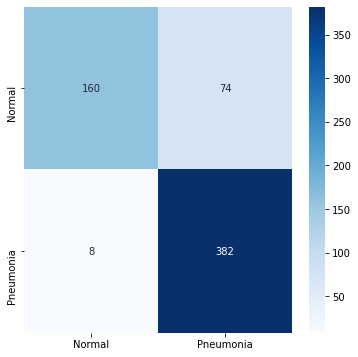

In [34]:
conf = mtr.confusion_matrix(true, pred)
print(f'Precision Score : {mtr.precision_score(true, pred)*100:3f}')
print(f'Recall Score : {mtr.recall_score(true, pred)*100:3f}')
fig,ax = plt.subplots(figsize=(6,6))
fig = sns.heatmap(conf, annot=True, fmt='.4g', xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'], ax=ax, cmap='Blues')

In [45]:
for param in model.parameters():
  param.requires_grad = True
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-3, momentum=0.7, weight_decay=0.0005)
num_epochs = 10

In [46]:
best_model = model.state_dict()
for i in range(num_epochs):
  print(f"Epoch {i+1}\n-------------------------------")
  start_time = time.time()
  train(train_dataloader, model.to(device), loss_fn, optimizer)
  test_loss = test(test_dataloader, model.to(device))
  if test_loss < best_loss_score:
    best_loss_score = test_loss
    best_model = model.state_dict()
    print("Best performing model captured & saved")
  end_time = time.time()
  print(f"Epoch Execution Time :=> {np.round(end_time - start_time, 3)} sec")

Epoch 1
-------------------------------
loss: 0.411856  [ 0/82]
loss: 0.390521  [ 8/82]
loss: 0.392098  [16/82]
loss: 0.399520  [24/82]
loss: 0.418372  [32/82]
loss: 0.406580  [40/82]
loss: 0.405945  [48/82]
loss: 0.408586  [56/82]
loss: 0.396429  [64/82]
loss: 0.424746  [72/82]
loss: 0.406363  [80/82]
Test Error: 
 Accuracy: 85.3%, Avg loss:0.007718 

Epoch Execution Time :=> 166.413 sec
Epoch 2
-------------------------------
loss: 0.402654  [ 0/82]
loss: 0.405204  [ 8/82]


KeyboardInterrupt: ignored

In [47]:
model.load_state_dict(best_model)

<All keys matched successfully>

Precision Score : 83.956044
Recall Score : 97.948718


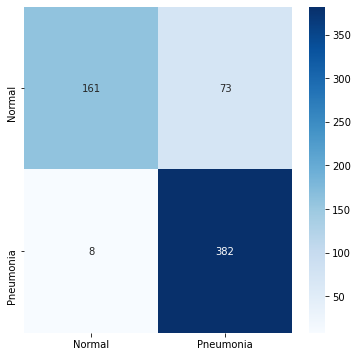

In [48]:
pred = list()
true = list()
with torch.no_grad():
  model.to(device)
  for X, y in test_dataloader:
    true.append(y)
    y_pred = model(X.float().to(device))
    pred.append(y_pred)

pred = np.argmax(np.array([tuple(j) for i in pred for j in i.to('cpu').numpy()]),axis=1)
true = np.array([j for i in true for j in i.numpy()])

conf = mtr.confusion_matrix(true, pred)
print(f'Precision Score : {mtr.precision_score(true, pred)*100:3f}')
print(f'Recall Score : {mtr.recall_score(true, pred)*100:3f}')
fig,ax = plt.subplots(figsize=(6,6))
fig = sns.heatmap(conf, annot=True, fmt='.4g', xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'], ax=ax, cmap='Blues')